<a href="https://colab.research.google.com/github/ayush9818/brain-tumour-detection/blob/main/Brain_Tumor_Classification_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm
import time
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/brain_tumor_dataset/df.csv')
train_df = df[df['type']=='train']
print(train_df.shape)

valid_df = df[df['type']=='valid']
print(valid_df.shape)

(1494, 5)
(262, 5)


In [ ]:
IMG_HEIGHT, IMG_WIDTH  = (240,240)

In [ ]:
def crop_brain_contour(image):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return new_image            

In [ ]:
def load_data(df, img_height, img_width):
  X = []
  y = []
  for idx,sample in df.iterrows():
    image_path = sample['image_path']
    image = cv2.imread(image_path)
    image = crop_brain_contour(image)
    image = cv2.resize(image, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
    image = image / 255.
    X.append(image)
    if sample['label'] == "yes":
      y.append(1)
    else:
      y.append(0)
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = load_data(train_df, IMG_HEIGHT, IMG_WIDTH)
print("Shape of X_train : {}".format(X_train.shape))
print("Shape of y_train : {}".format(y_train.shape))

Shape of X_train : (1494, 240, 240, 3)
Shape of y_train : (1494,)


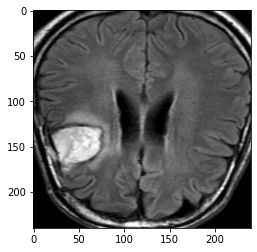

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [ ]:
X_val, y_val = load_data(valid_df, IMG_HEIGHT, IMG_WIDTH)
print("Shape of X_val : {}".format(X_val.shape))
print("Shape of y_val : {}".format(y_val.shape))

Shape of X_val : (262, 240, 240, 3)
Shape of y_val : (262,)


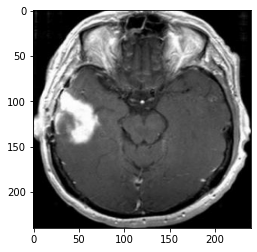

In [ ]:
plt.imshow(X_val[0])

In [ ]:
def build_model(input_shape):
  X_input = Input(input_shape)
  X = ZeroPadding2D((2, 2))(X_input)
  X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
  X = BatchNormalization(axis = 3, name = 'bn0')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((4, 4), name='max_pool0')(X)
  X = MaxPooling2D((4, 4), name='max_pool1')(X)
  X = Flatten()(X)
  X = Dense(1, activation='sigmoid', name='fc')(X)
  
  model = Model(inputs = X_input, outputs = X)
  
  return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)        0     

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
filepath="/content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/15
47/47 [==============================] - 110s 2s/step - loss: 1.0159 - accuracy: 0.5612 - val_loss: 0.6457 - val_accuracy: 0.7061

Epoch 00001: val_accuracy improved from -inf to 0.70611, saving model to /content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-01-0.71.hdf5
Epoch 2/15
47/47 [==============================] - 109s 2s/step - loss: 0.4708 - accuracy: 0.7764 - val_loss: 0.6910 - val_accuracy: 0.5267

Epoch 00002: val_accuracy did not improve from 0.70611
Epoch 3/15
47/47 [==============================] - 109s 2s/step - loss: 0.4363 - accuracy: 0.8092 - val_loss: 0.6255 - val_accuracy: 0.5573

Epoch 00003: val_accuracy did not improve from 0.70611
Epoch 4/15
47/47 [==============================] - 109s 2s/step - loss: 0.4377 - accuracy: 0.8000 - val_loss: 0.7062 - val_accuracy: 0.5611

Epoch 00004: val_accuracy did not improve from 0.70611
Epoch 5/15
47/47 [==============================] - 109s 2s/step - loss: 0.3366 - accuracy: 0.8511 - val_loss: 0

In [ ]:
history = model.history.history
for key in history.keys():
  print(key)

loss
accuracy
val_loss
val_accuracy


In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

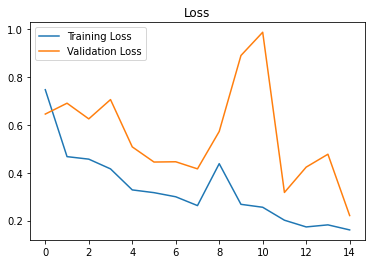

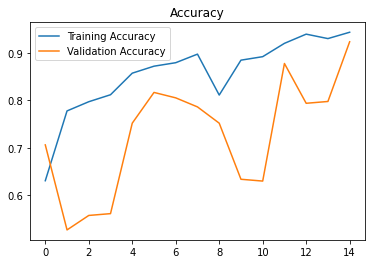

In [ ]:
plot_metrics(history)

In [ ]:
test_df = df[df['type']=='test']
test_df.head()

,Unnamed: 0,image_path,image_name,type,label
785,785,/content/drive/MyDrive/brain_tumor_dataset/aug...,aug_Y59_0_8317.jpg,test,yes
786,786,/content/drive/MyDrive/brain_tumor_dataset/aug...,aug_Y186_0_3501.jpg,test,yes
787,787,/content/drive/MyDrive/brain_tumor_dataset/aug...,aug_Y242_0_971.jpg,test,yes
788,788,/content/drive/MyDrive/brain_tumor_dataset/aug...,aug_Y2_0_9808.jpg,test,yes
789,789,/content/drive/MyDrive/brain_tumor_dataset/aug...,aug_Y33_0_9020.jpg,test,yes


In [ ]:
X_test, y_test = load_data(test_df, IMG_HEIGHT, IMG_WIDTH)
print(X_test.shape)
print(y_test.shape)

(308, 240, 240, 3)
(308,)


In [ ]:
final_model = load_model('/content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-15-0.92.hdf5')
print("model loaded")

model loaded


In [ ]:
loss, accuracy = final_model.evaluate(X_test, y_test)

10/10 [==============================] - 6s 540ms/step - loss: 0.2798 - accuracy: 0.8831


In [ ]:
y_pred = final_model.predict(X_test)

for i in range(y_pred.shape[0]):
  if y_pred[i]>=0.5:
    y_pred[i]=1
  else:
    y_pred[i]=0

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[132,  14],
       [ 22, 140]])

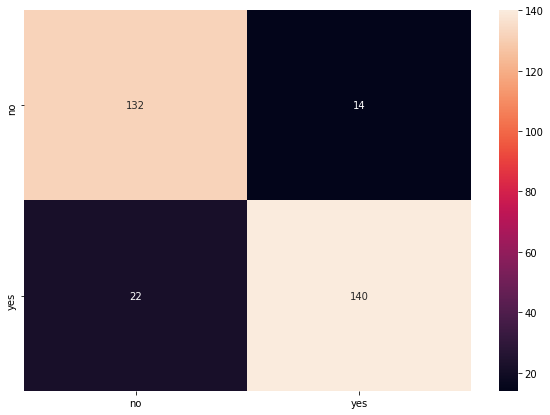

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = ['no', 'yes'],
                  columns = ["no","yes"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       146
           1       0.91      0.86      0.89       162

    accuracy                           0.88       308
   macro avg       0.88      0.88      0.88       308
weighted avg       0.88      0.88      0.88       308

